# Семинар 12

# Негладкая оптимизация: субградиентный метод

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib
import cvxpy as cvx
from step_size import ConstantStepSize, SeqStepSize, StepSize

In [2]:
matplotlib.use('Agg')
params = {'legend.fontsize': 20,
          'legend.handlelength': 4,
          "axes.labelsize": 45,
          "xtick.labelsize": 25,
          "ytick.labelsize": 25,
          "lines.linewidth": 4,
           "axes.titlesize":30}
matplotlib.rcParams.update(params)

## 1. Субградиент и условия оптимальности


**Определение.** Вектор $g(x)$ называется *субградиентом* функции $f$ в точке $x$, если $\forall y\in X$ выполнено

$$f(y) \geq f(x) + \langle g(x), y - x \rangle$$

*Субдифференциал* $\partial f(x)$ - это множество всех субградиентов.

### 1.1. Оптимальность безусловной задачи оптимизации

$$\min_{\mathbf{x}\in\mathbb{R}^n} f(\mathbf{x})$$

**Если $f(x^*)=\min_x f(x)$, то $0\in \partial f(x^*).$**

### 1.2. Условия ККТ

$$\min_{\mathbf{x}\in\mathbb{R}^n} f_0(\mathbf{x})$$

$$\text{s.t. } g_i(\mathbf{x})\leq 0, i=\overline{1, p}$$
$$h_i(\mathbf{x}) = 0, i=\overline{1, m}$$

Условия ККТ для лагранжиана с субдифференциалом:

1. $g_i(\mathbf{x})\leq 0, i=\overline{1, p}$

2. $h_i(\mathbf{x}) = 0, i=\overline{1, m}$

3. $\lambda \in \mathbb{R}^p_+$

4. $\lambda_i g_i(\mathbf{x})=0, i=\overline{1, p}$

5. $x\in \arg\min L(x, \lambda, nu)$

Для дифференцируемого по $x$ лагранжиана 5ое условие сводится к

$0= \nabla L(\mathbf{x}, \lambda, \nu)$

Для лагранжиана с субдифференциалом 5ое условие сводится к 

$0\in \partial_x L(\mathbf{x}, \lambda, \nu)= \partial_x f(\mathbf{x})+\sum\limits_{i=1}^p \lambda_i \partial g_i(\mathbf{x}) + \sum\limits_{i=1}^m \nu \partial h_i(\mathbf{x})$

### 2. Субградиентный метод

Итерация субградиентного метода:

$$\mathbf{x}_{k+1} = \mathbf{x}_k - \alpha_k \mathbf{g}_k,$$

где $\mathbf{g}_k$ - субградиент в $\mathbf{x}_k$.

Размер шага:

* Fixed step: $\alpha_k=\alpha_0$

* Убывающая последовательность: $\alpha_k>0, \sum\limits_{i=1}^n \alpha_i =\infty, \sum\limits_{i=1}^n \alpha_i^2 <\infty$, $\alpha_k = \frac{\alpha_0}{k+1}$

* Scaled gradient norm: $\alpha_k=\frac{\alpha_0}{\|g_k\|}$

* Polyak step size: $\alpha_k=\frac{f_k-f^*}{\|g_k\|^2}$

In [3]:
class ScaledConstantStepSize(StepSize):
    def __init__(self, alpha0=1):
        self.alpha0 = alpha0
    
    def __call__(self, x, h, k, gradf, f, *args, **kwargs):
        return self.alpha0 / np.linalg.norm(gradf(x))

In [4]:
class GradientDescent:
    def __init__(self, StepSizeChoice, return_history=True, name=None):
        self.name = name
        self.StepSizeChoice = StepSizeChoice
        self.return_history = return_history
        self.history = []
    
    def solve(self, x0, f, gradf, tol=1e-3, max_iter=10000):
        self.history = [(x0, time.time())]
        x = x0.copy()
        k = 0
        x_prev = None
        while x_prev is None or np.linalg.norm(x-x_prev) > tol: 
            h = -gradf(x)
            alpha = self.StepSizeChoice(x, h, k, gradf, f)
            x_prev, x = x, x + alpha * h
            if self.return_history:
                self.history.append((x, time.time()))
            if k >= max_iter:
                break
            k += 1
        return x


def parse_logs(xhistory, ret_time=False, funcx=None):
    values = [funcx(x) for x, _ in xhistory]
    if ret_time:
        times = [t for _, t in xhistory]
        times = [times[ind]-times[0] for ind, t in enumerate(times)]
    else:
        times = [i for i in range(len(xhistory))]
    return times, values

In [5]:
def alpha_function1(k):
    return min(1e-1/(k+1), 1e-4)

### 1.4. Эксперименты: Решение СЛАУ, $m\leq n$

$$\min_x f(x) = \|Ax-b\|_1$$

$$\min_x f(x) =  \|Ax-b\|_2^2$$

In [19]:
def func(x, A, b):
    return np.abs(A.dot(x) - b).sum()

def grad_f(x, A, b):
    y = (A.dot(x) - b)
    return A.T @ np.sign(y)

In [20]:
np.random.seed(1)
n = 500
m = 100
A = np.random.randn(m, n)
x_true = np.random.rand(n)
b = A.dot(x_true)
x0 = np.ones(n)
f = lambda x: func(x, A, b)
gradf = lambda x: grad_f(x, A, b)

In [21]:
methods = [GradientDescent(ScaledConstantStepSize(1e-2), name="GD, scaled"),
          GradientDescent(ConstantStepSize(1e-4), name="GD, const"),
          GradientDescent(SeqStepSize(d=1, alpha0=2), name="GD, 1/k"),
          GradientDescent(SeqStepSize(alpha_function=alpha_function1), name="GD, custom"),
          ]

In [22]:
for method in methods:
    method.solve(x0, f, gradf, tol=1e-9, max_iter=10000)

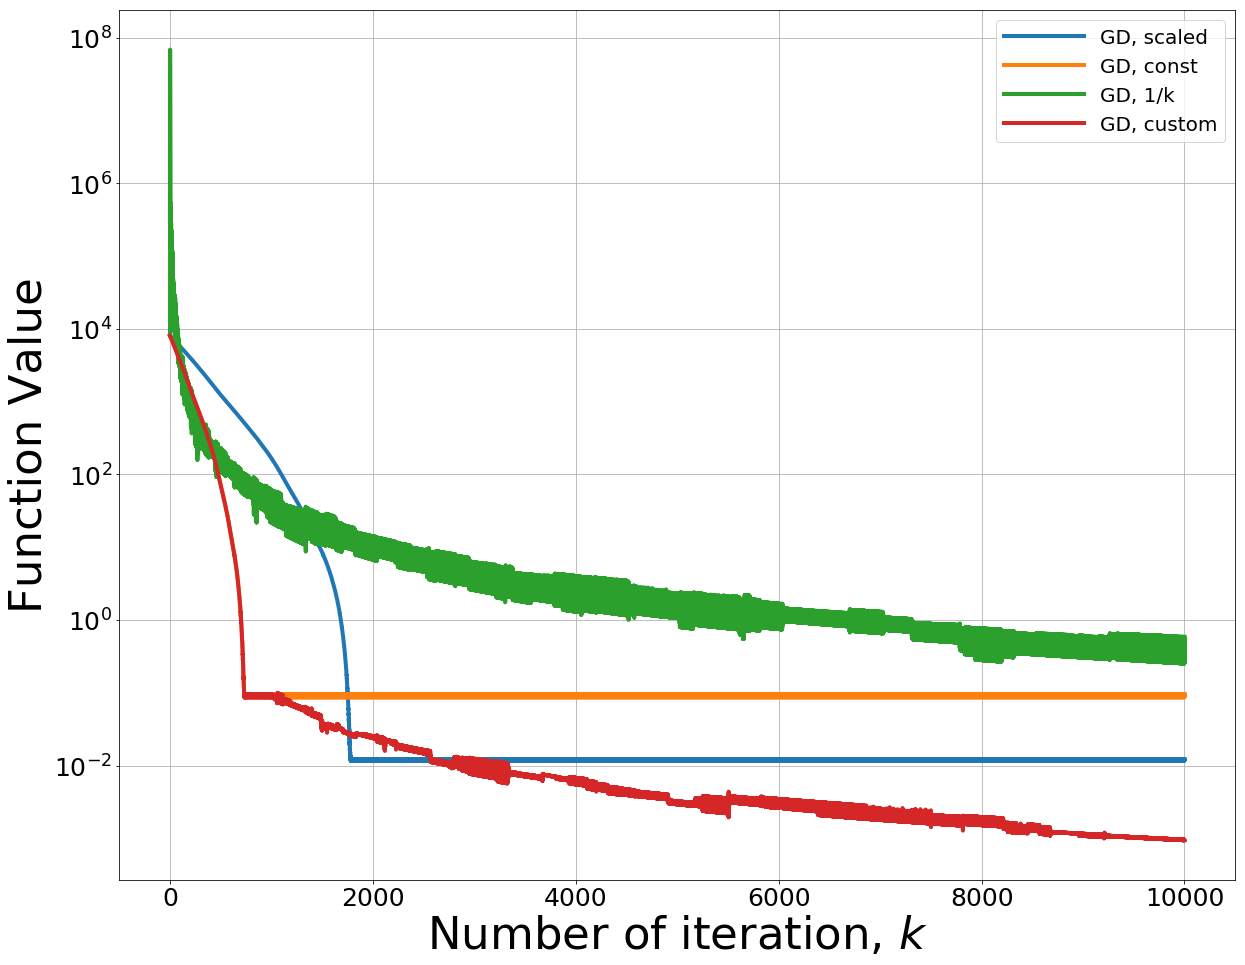

In [23]:
%matplotlib inline
plt.figure(figsize=(20, 16))
funcx = lambda x: 1/2 * np.linalg.norm(A @ x -b, 2)**2
#funcx = lambda x: f(x)
for method in methods:
    xhistory = method.history
    times, values = parse_logs(method.history, ret_time=False, funcx=funcx)
    plt.semilogy(times, values, label=method.name)
plt.grid()
plt.ylabel(r"Function Value")
plt.xlabel(r"Number of iteration, $k$")
plt.legend()

In [15]:
f = lambda x: 0.5 * np.linalg.norm(A.dot(x) - b)**2
gradf = lambda x: A.T.dot(A.dot(x) - b)

In [16]:
methods = [GradientDescent(ConstantStepSize(1e-3), name="GD, const")]
for method in methods:
    method.solve(x0, f, gradf, tol=1e-9, max_iter=10000)

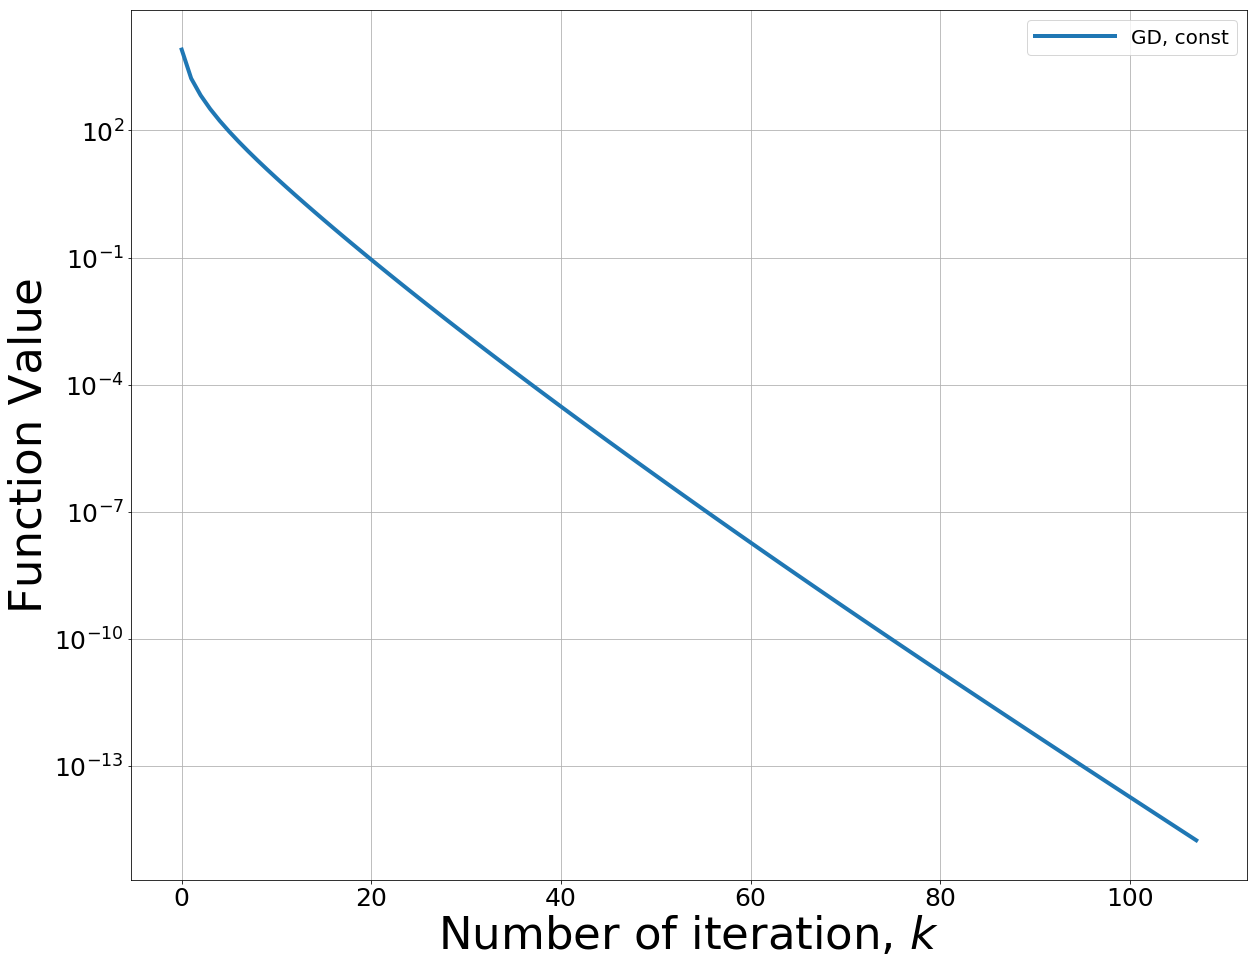

In [17]:
%matplotlib inline
plt.figure(figsize=(20, 16))
funcx = lambda x: 1/2 * np.linalg.norm(A @ x -b)**2
#funcx = lambda x: f(x)
for method in methods:
    xhistory = method.history
    times, values = parse_logs(method.history, ret_time=False, funcx=funcx)
    plt.semilogy(times, values, label=method.name)
plt.grid()
plt.ylabel(r"Function Value")
plt.xlabel(r"Number of iteration, $k$")
plt.legend()

### 1.5. Эксперименты: Решение СЛАУ

$$\min_x \|Ax-b\|_1$$

* Polyak step size: $\alpha_k=\frac{f_k-f^*}{\|g_k\|^2}$

In [27]:
class PolyakStepSize(StepSize):
    def __init__(self, f_sol=0):
        self.f_sol = f_sol
    
    def __call__(self, x, h, k, gradf, f, *args, **kwargs):
        return (f(x)-self.f_sol) / np.linalg.norm(gradf(x))**2

In [28]:
def func(x, A, b):
    return np.abs(A.dot(x) - b).sum()

def grad_f(x, A, b):
    y = (A.dot(x) - b)
    return A.T @ np.sign(y)

In [29]:
np.random.seed(1)
n = 500
m = 100
A = np.random.randn(m, n)
x_true = np.random.rand(n)
b = A.dot(x_true)
x0 = np.ones(n)
f = lambda x: func(x, A, b)
gradf = lambda x: grad_f(x, A, b)

In [46]:
methods = [
          GradientDescent(SeqStepSize(alpha_function=alpha_function1), name="GD, custom"),
          GradientDescent(PolyakStepSize(0), name="GD, Polyak"),
          ]

In [47]:
for method in methods:
    method.solve(x0, f, gradf, tol=1e-9, max_iter=2000)

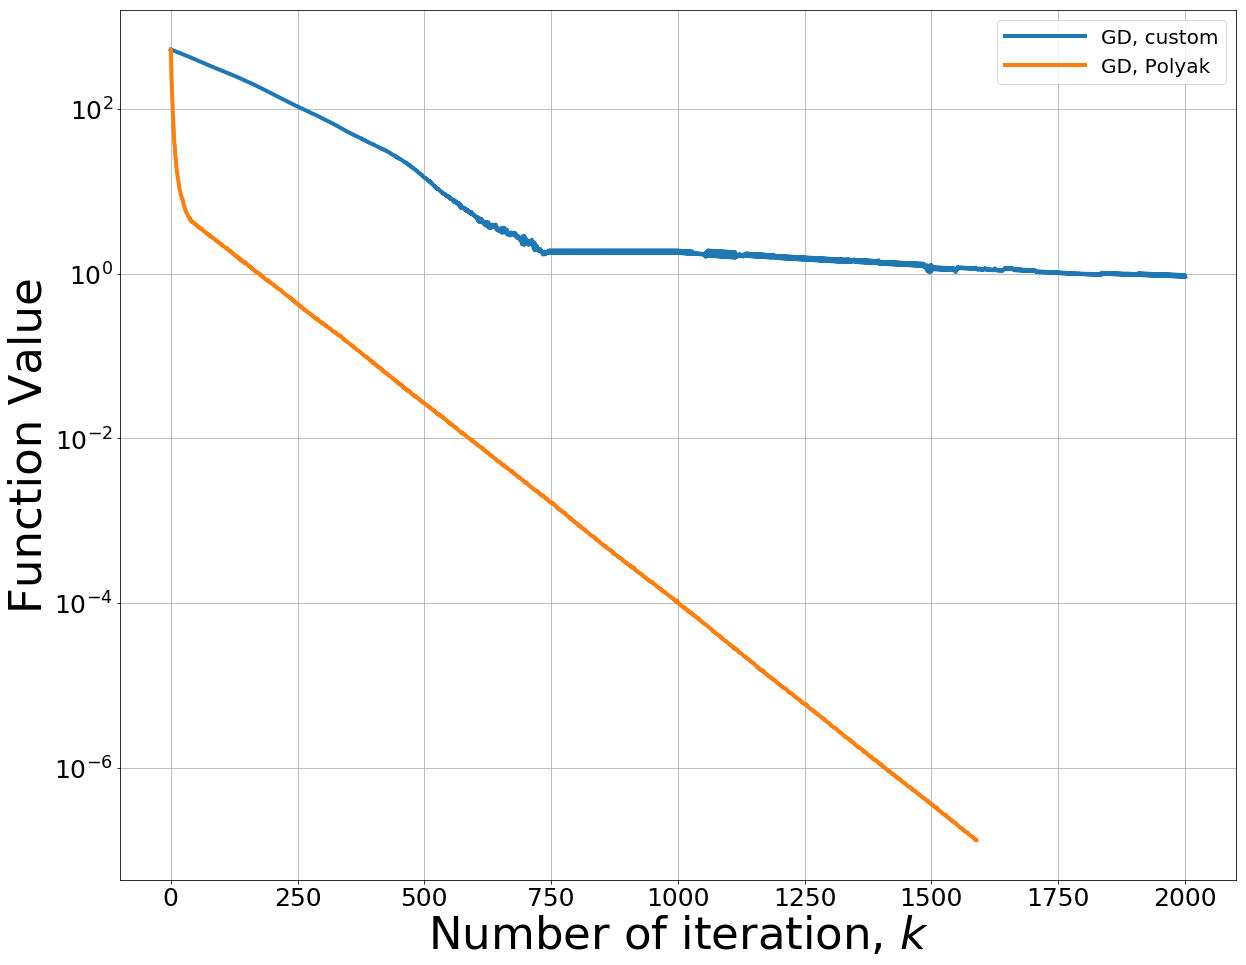

In [48]:
%matplotlib inline
plt.figure(figsize=(20, 16))
funcx = lambda x: 1/2 * np.linalg.norm(A @ x -b, 1)
#funcx = lambda x: f(x)
for method in methods:
    xhistory = method.history
    times, values = parse_logs(method.history, ret_time=False, funcx=funcx)
    plt.semilogy(times, values, label=method.name)
plt.grid()
plt.ylabel(r"Function Value")
plt.xlabel(r"Number of iteration, $k$")
plt.legend()

In [49]:
np.random.seed(1)
n = 500
m = 1000
A = np.random.randn(m, n)
x_true = np.random.randn(n)
b = A.dot(x_true) + np.random.randn(m)
x0 = np.ones(n)
f = lambda x: func(x, A, b)
gradf = lambda x: grad_f(x, A, b)

In [50]:
f_l2 = lambda x: 0.5 * np.linalg.norm(A.dot(x) - b)**2
gradf_l2 = lambda x: A.T.dot(A.dot(x) - b)

In [51]:
method = GradientDescent(SeqStepSize(alpha_function=alpha_function1), name="GD, Polyak")
x_l1 = method.solve(x0, f, gradf, tol=1e-4, max_iter=6000)
print(f(x_l1), f_l2(x_l1))
method = GradientDescent(ConstantStepSize(1e-4), name="GD, const")
x_l2 = method.solve(x0, f_l2, gradf_l2, tol=1e-4, max_iter=10000)
print(f(x_l2), f_l2(x_l2))

457.2038201338976 338.81551084576245
541.9956759936616 235.64281237456623


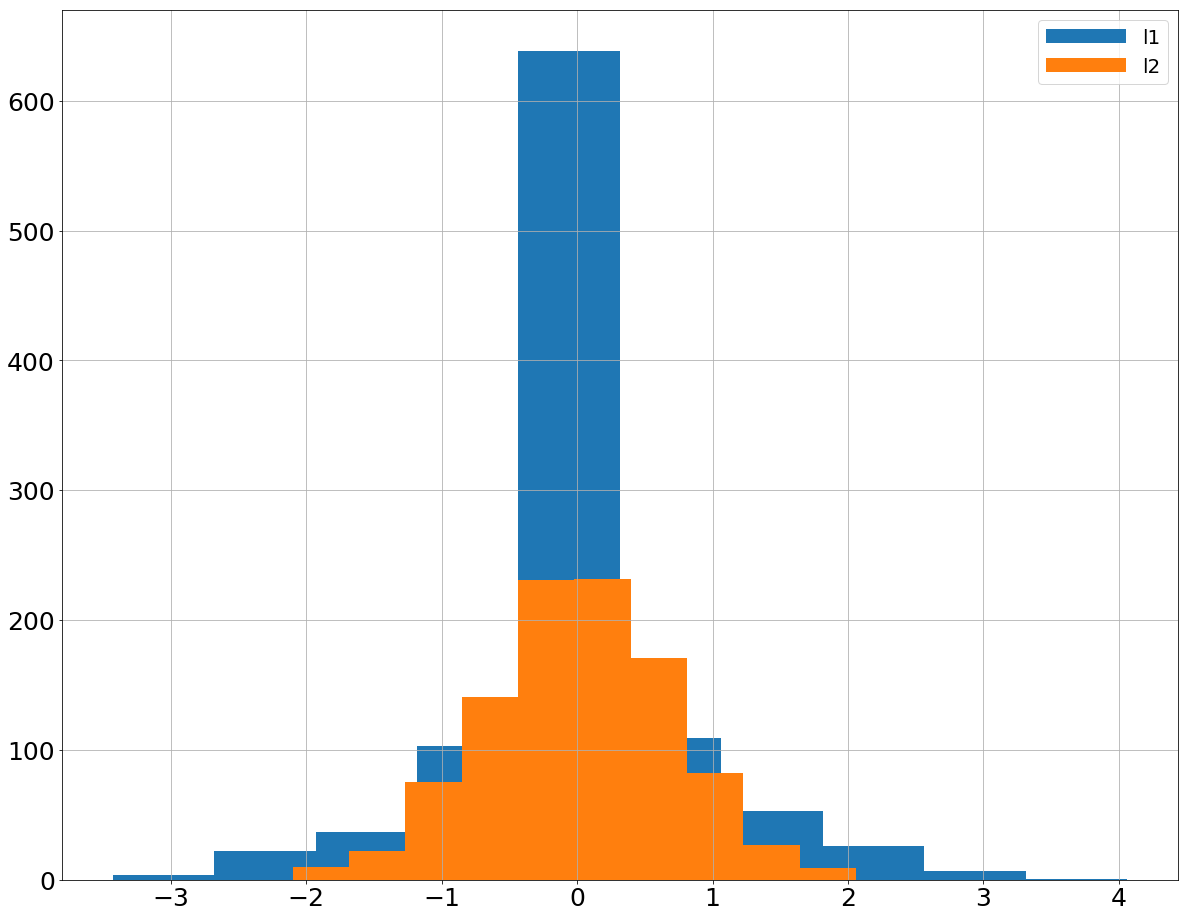

In [54]:
plt.figure(figsize=(20, 16))
plt.hist(A@x_l1-b, label="l1")
plt.hist(A@x_l2-b, label="l2")
plt.legend()
plt.grid()

### 1.6. Эксперименты: LASSO
LASSO (Least Absolute Shrinkage and Selection Operator):

$$\min_x \|Ax-b\|_2^2 + \sigma \|x\|_1$$

In [55]:
def func(x, A, b, sigma):
    return 1/2 * np.linalg.norm(A @ x - b)**2 + sigma * np.abs(x).sum()

def grad_f(x, A, b, sigma):
    y = (A.dot(x) - b)
    return A.T @ (A @ x - b) + sigma * np.sign(x)

In [56]:
np.random.seed(1)
n = 500
m = 100
A = np.random.randn(m, n)
x_true = np.random.rand(n)
b = A.dot(x_true)
x0 = np.zeros(n)
sigma = 10
eps = 1e-9
f = lambda x: func(x, A, b, sigma)
gradf = lambda x: grad_f(x, A, b, sigma)

In [57]:
x = cvx.Variable(n)
obj = cvx.Minimize(1/2 * cvx.norm(A@x-b)**2 + sigma * cvx.norm(x, 1))
cvx.Problem(obj).solve()
x = x.value
f(x), np.sum(np.abs(x)<=eps)

(729.504605314765, 359)

In [58]:
methods = [GradientDescent(ConstantStepSize(1e-3), name="GD, const"),
          GradientDescent(SeqStepSize(d=2/3, alpha0=1.5e-2), name="GD, 1/k")]

In [59]:
for method in methods:
    x = method.solve(x0, f, gradf, tol=1e-9, max_iter=40000)
    print(method.name, f(x))

GD, const 745.7966934507057
GD, 1/k 731.1795063731603


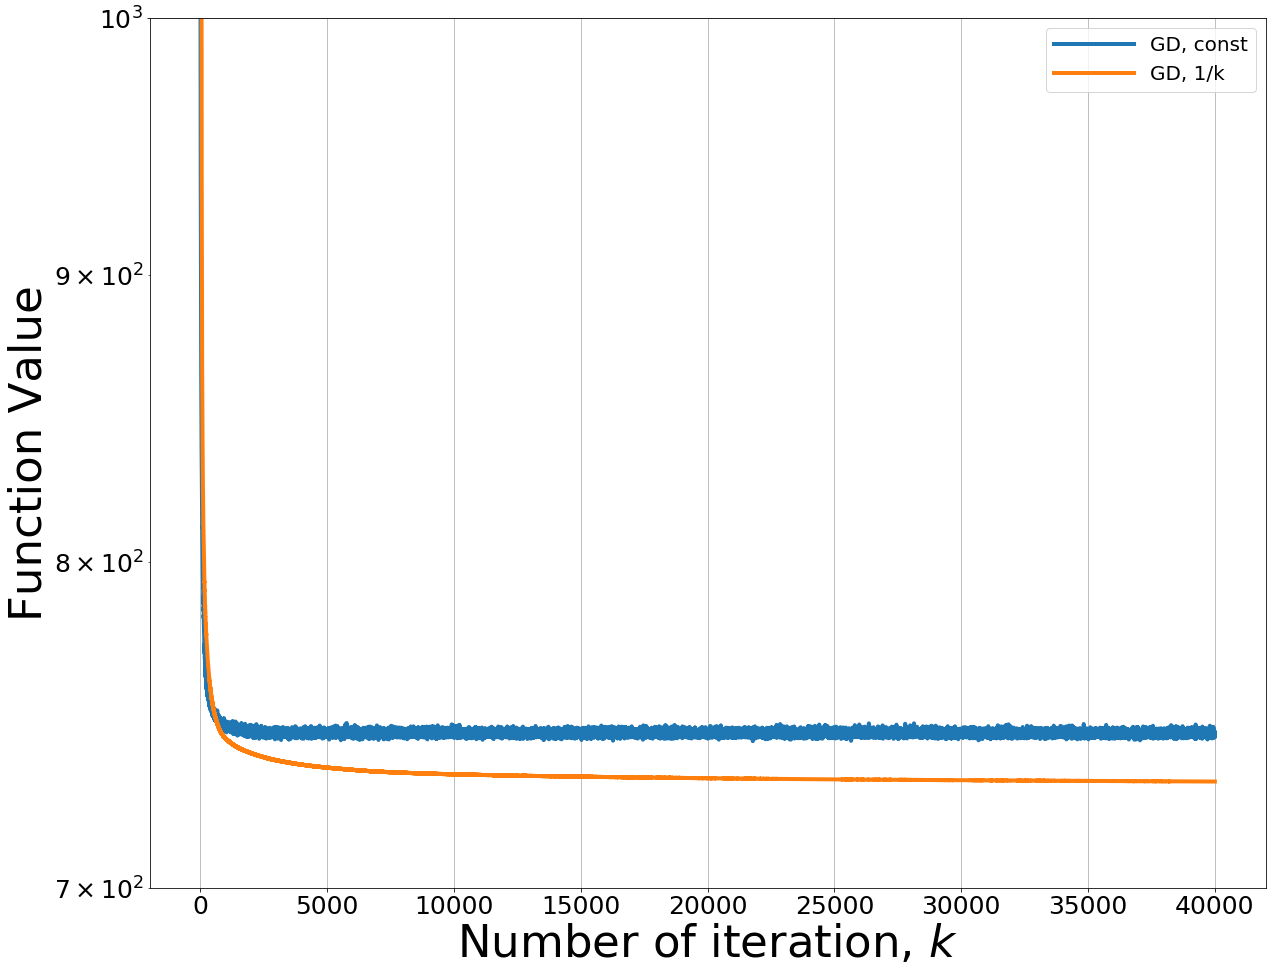

In [60]:
%matplotlib inline
plt.figure(figsize=(20, 16))
funcx = lambda x: f(x)
#funcx = lambda x: f(x)
for method in methods:
    xhistory = method.history
    times, values = parse_logs(method.history, ret_time=False, funcx=funcx)
    plt.semilogy(times, values, label=method.name)
plt.grid()
plt.ylim(700, 1000)
plt.ylabel(r"Function Value")
plt.xlabel(r"Number of iteration, $k$")
plt.legend()

In [61]:
np.sum(np.abs(x)<=1e-9), np.sum(np.abs(x)<=1e-4)

(0, 259)

## Summary

1. Условия оптимальности для негладких задач

2. Субградиентный метод